In [39]:
!pip install seaborn
!pip install matplotlib
!pip install scipy

In [1]:
%matplotlib inline

In [141]:
# Required modules

import os
import re
import warnings
warnings.filterwarnings('ignore')
from glob import glob

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt

In [142]:
# Reading data

data_path = "data"
csv_paths = glob(os.path.join(data_path, "*.csv"))
raw_data = {cp.rsplit('Data Analyst Assignment Round - ', 1)[-1].rsplit('.csv')[0]: pd.read_csv(cp) for cp in csv_paths}

In [150]:
# Data Cleaning

data = {}

for k, df in raw_data.items():
    if "Module" in k:
        df = df.sort_values('Date Completed (UTC)')
        data[k] = df.drop_duplicates('Student ID', keep='first')
    else:
        data[k] = df
    data[k] = data[k].set_index('Student ID')
    
for i in range(1, 4):
    # print(len(data[f'Module {i} PreTest']), len(data[f'Module {i} PostTest']))
    idx = data[f'Module {i} PreTest'].index.intersection(data[f'Module {i} PostTest'].index)
    data[f'Module {i} PreTest'] = data[f'Module {i} PreTest'].loc[idx]
    data[f'Module {i} PostTest'] = data[f'Module {i} PostTest'].loc[idx]

## Overall impact of each module
### Visualising PreTest and PostTest score distributions

A right shifted PostTest score distribution (compared to PreTest score distribution) would hint a postive impact of the module.

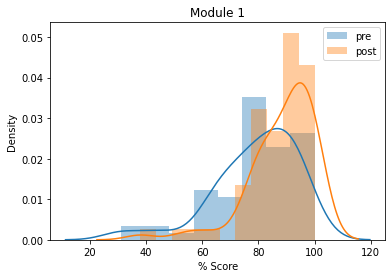

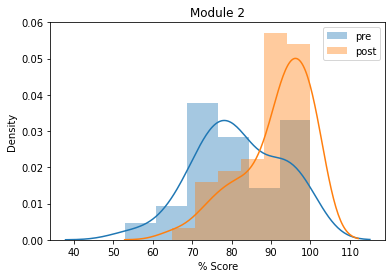

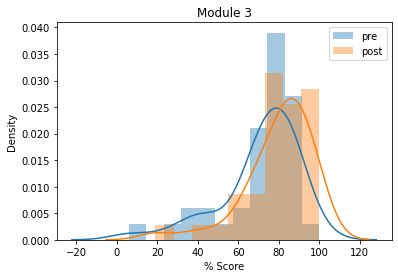

In [151]:
for i in range(1, 4):
    sns.distplot(data[f'Module {i} PreTest']['% Score'], label='pre')
    sns.distplot(data[f'Module {i} PostTest']['% Score'], label='post')
    plt.legend()
    plt.title(f"Module {i}")
    plt.show()

The above plots show a hint of positive impact. To quantify it, we can define it as the change in score.

i.e., **impact = PostTest % Score - PreTest % Score**

In following cell we visualize the distribution of impact.

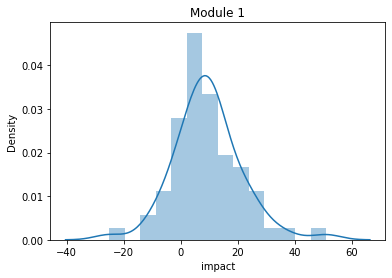

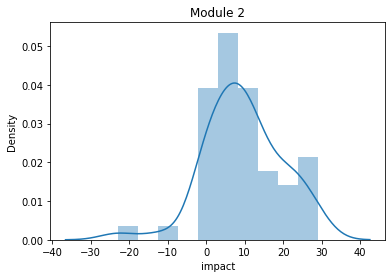

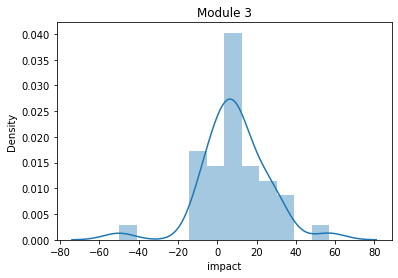

        Module 1   Module 2   Module 3
count  66.000000  54.000000  39.000000
mean    9.439394   9.648148   8.948718
std    11.829726  10.028558  16.640073
min   -25.000000 -23.000000 -50.000000
25%     1.250000   6.000000   0.000000
50%     7.000000   8.000000   7.000000
75%    13.000000  16.500000  15.500000
max    51.000000  29.000000  57.000000


In [157]:
score_diff = pd.DataFrame()

for i in range(1, 4):
    score_diff[f'Module {i}'] = data[f'Module {i} PostTest']['% Score']-data[f'Module {i} PreTest']['% Score']
    sns.distplot(score_diff[f'Module {i}'])
    plt.xlabel('impact')
    plt.title(f"Module {i}")
    plt.show()
    
print(score_diff.describe())

### Hypothesis Testing

We will use Hypothesis Testing to check if the impact we saw above is by chance or is caused by the module. As central limit theorem states, the distribution of sample means approximates a normal distribution as the sample size gets larger. Therefore we will assume a normal distribution for average impact of a module.

**Null Hypothesis:** Module has no impact i.e., average impact (say m) follows distribution with mean = 0</br>
**Alternate Hypothesis:** mean of m > 0</br>
**Significance level:** 0.05 (Most commonly used)</br>
**Test statistic:** observed value of m = observed average impact</br>
**p-value:** Assuming null hypothesis is true, probability of obtaining m greater than or equal to observed value i.e., P(m >= observed value of m)

*Note*: Standard deviation (std) of distribution of m (under null hypothesis) can be approximated as std(sample)/sqrt(count).

In [160]:
alpha = 0.05

for i in range(1, 4):
    print(f"\nModule {i}:")
    mean = 0
    stddev = score_diff[f'Module {i}'].std()/np.sqrt(score_diff[f'Module {i}'].count())
    p_val = 1-stats.norm.cdf(score_diff[f'Module {i}'].mean(), mean, stddev)
    print(f"p-value = {p_val}", end='')
    if p_val < alpha:
        print(f" < alpha => we reject null hypothesis. i.e., Module {i} has +ve impact")
        mean_impact_lb = np.round(score_diff[f'Module {i}'].mean() - 2*stddev,2)
        mean_impact_ub = np.round(score_diff[f'Module {i}'].mean() + 2*stddev, 2)
        print(f"With 95% confidence average impact of Module {i} lies in ({mean_impact_lb}, {mean_impact_ub})")
    else:
        print(f">= alpha => we don't have enough evidence to reject null hypothesis. i.e., impact could be by chance")


Module 1:
p-value = 4.511269136031615e-11 < alpha => we reject null hypothesis. i.e., Module 1 has +ve impact
With 95% confidence average impact of Module 1 lies in (6.53, 12.35)

Module 2:
p-value = 7.762679388179095e-13 < alpha => we reject null hypothesis. i.e., Module 2 has +ve impact
With 95% confidence average impact of Module 2 lies in (6.92, 12.38)

Module 3:
p-value = 0.0003919154342721942 < alpha => we reject null hypothesis. i.e., Module 3 has +ve impact
With 95% confidence average impact of Module 3 lies in (3.62, 14.28)


## Age-wise impact

In [163]:
# Cleaning to get age

date_re = r'[1-2]\d{3}'
age_re = r'\d+'

def get_age(ts, res):
    match = re.search(date_re, res)
    if match is not None:
        return int(re.search(date_re, ts).group(0)) - int(match.group(0))
    
    match = re.search(age_re, res)
    if match is not None:
        return int(match.group(0))
    
    return None

score_diff['age'] = data['Demographic Data'].iloc[:,[0,3]].apply(lambda row: get_age(row[0], row[1]), axis=1).dropna()  # dropping rows where we don't have age

In [222]:
print(score_diff.groupby(pd.cut(score_diff['age'], [0, 30, 40, 60])).mean(), '\n')
print(score_diff.groupby(pd.cut(score_diff['age'], [0, 30, 40, 60])).mean(), '\n')
print(score_diff.mean())

           Module 1   Module 2   Module 3        age
age                                                 
(0, 30]   10.848485  10.214286  11.952381  26.484848
(30, 40]   7.142857   6.400000   6.600000  34.619048
(40, 60]   9.583333  12.636364   4.000000  49.583333 

Module 1     9.439394
Module 2     9.648148
Module 3     8.948718
age         33.272727
dtype: float64


In [223]:
score_diff.groupby(pd.cut(score_diff['age'], [0, 30, 40, 60])).count()

,Module 1,Module 2,Module 3,age
age,,,,
"(0, 30]",33,28,21,33
"(30, 40]",21,15,10,21
"(40, 60]",12,11,8,12


In [181]:
pd.cut?

Signature:
pd.cut(
    x,
    bins,
    right: bool = True,
    labels=None,
    retbins: bool = False,
    precision: int = 3,
    include_lowest: bool = False,
    duplicates: str = 'raise',
    ordered: bool = True,
)
Docstring:
Bin values into discrete intervals.

Use `cut` when you need to segment and sort data values into bins. This
function is also useful for going from a continuous variable to a
categorical variable. For example, `cut` could convert ages to groups of
age ranges. Supports binning into an equal number of bins, or a
pre-specified array of bins.

Parameters
----------
x : array-like
    The input array to be binned. Must be 1-dimensional.
bins : int, sequence of scalars, or IntervalIndex
    The criteria to bin by.

    * int : Defines the number of equal-width bins in the range of `x`. The
      range of `x` is extended by .1% on each side to include the minimum
      and maximum values of `x`.
    * sequence of scalars : Defines the bin edges allowing for non-uni